In [14]:
import numpy as np
import os
import tensorflow as tf
# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt


# Time series 

In [15]:
t_min, t_max = 0, 30
resolution = 0.1

def time_series(t):
    return t * np.sin(t) / 3 + 2 * np.sin(t*5)

def next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    ys = time_series(Ts)
    return Ts, ys[:, :-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1)

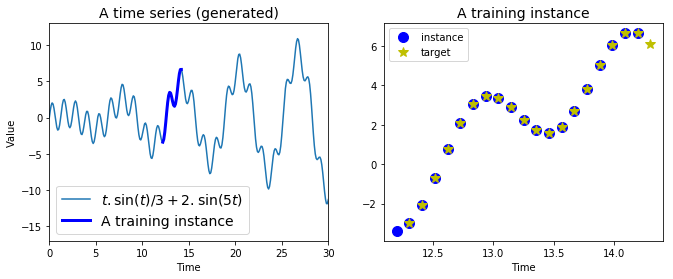

In [16]:
t = np.linspace(t_min, t_max, int((t_max - t_min) / resolution))

n_steps = 20
t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1)

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.title("A time series (generated)", fontsize=14)
plt.plot(t, time_series(t), label=r"$t . \sin(t) / 3 + 2 . \sin(5t)$")
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "b-", linewidth=3, label="A training instance")
plt.legend(loc="lower left", fontsize=14)
plt.axis([0, 30, -17, 13])
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.title("A training instance", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "y*", markersize=10, label="target")
plt.legend(loc="upper left")
plt.xlabel("Time")


plt.show()

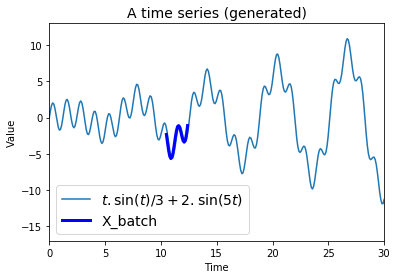

In [17]:
time_batch, X_batch, y_batch = next_batch(1, n_steps)
plt.figure(figsize=(6,4))

plt.title("A time series (generated)", fontsize=14)
plt.plot(t, time_series(t), label=r"$t . \sin(t) / 3 + 2 . \sin(5t)$")
plt.plot(time_batch.reshape(-1)[:-1], y_batch.reshape(-1), "b-", linewidth=3, label="X_batch")
plt.legend(loc="lower left", fontsize=14)
plt.axis([0, 30, -17, 13])
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

In [18]:
np.r_[X_batch.reshape(1,-1), y_batch.reshape(1,-1)]

array([[-1.40208096, -2.33035999, -3.4513234 , -4.52641909, -5.32081479,
        -5.66045846, -5.47433377, -4.81157012, -3.82922233, -2.75371563,
        -1.82539786, -1.23977629, -1.0998269 , -1.39105208, -1.98539218,
        -2.67303091, -3.214304  , -3.39899794, -3.09851497, -2.29812628],
       [-2.33035999, -3.4513234 , -4.52641909, -5.32081479, -5.66045846,
        -5.47433377, -4.81157012, -3.82922233, -2.75371563, -1.82539786,
        -1.23977629, -1.0998269 , -1.39105208, -1.98539218, -2.67303091,
        -3.214304  , -3.39899794, -3.09851497, -2.29812628, -1.10140997]])

In [19]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1
n_layers = 3

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])


# -----------basic RNN -----------------------------------
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu),
    output_size=n_outputs)

# -----------basic lstm -----------------------------------
# cell = tf.contrib.rnn.OutputProjectionWrapper(
#     tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons),
#     output_size=n_outputs)

# -----------basic GRU -----------------------------------
# cell = tf.contrib.rnn.OutputProjectionWrapper(
#     tf.contrib.rnn.CRUCell(num_units=n_neurons),
#     output_size=n_outputs)


# -----------multi layer lstm -----------------------------------
# lstm_cells = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)
#               for layer in range(n_layers)]
# multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)
# cell = tf.contrib.rnn.OutputProjectionWrapper(multi_cell, output_size=n_outputs)


outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)


learning_rate = 0.001

loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

saver = tf.train.Saver()

n_iterations = 1000
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        _, X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    saver.save(sess, "./my_time_series_model") # not shown in the book

with tf.Session() as sess:                          # not shown in the book
    saver.restore(sess, "./my_time_series_model")   # not shown

    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})
    


0 	MSE: 18.9177
100 	MSE: 0.762551
200 	MSE: 0.290907
300 	MSE: 0.149525
400 	MSE: 0.0772763
500 	MSE: 0.0665644
600 	MSE: 0.0636215
700 	MSE: 0.0559812
800 	MSE: 0.0554487
900 	MSE: 0.0529518
INFO:tensorflow:Restoring parameters from ./my_time_series_model


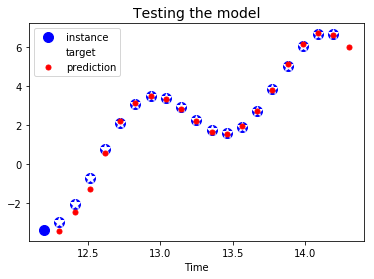

In [20]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")
plt.show()

# MNIST

In [21]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")
X_test = mnist.test.images.reshape((-1, 28, 28))
y_test = mnist.test.labels

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [22]:
reset_graph()

n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10
n_layers = 3

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

#----------------basic rnn cell -----------------------------
# cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
# outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
# logits = tf.layers.dense(states, n_outputs)

#----------------multi layer lstm-----------------------------
lstm_cells = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)
              for layer in range(n_layers)]
cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
top_layer_h_state = states[-1][1]
logits = tf.layers.dense(top_layer_h_state, n_outputs, name="softmax")

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                          logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

In [23]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size, shuffle=False)
            X_batch = X_batch.reshape((batch_size, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print("Epoch", epoch, "Train accuracy =", acc_train, "Test accuracy =", acc_test)

Epoch 0 Train accuracy = 0.96 Test accuracy = 0.9359
Epoch 1 Train accuracy = 0.946667 Test accuracy = 0.962
Epoch 2 Train accuracy = 0.986667 Test accuracy = 0.9787
Epoch 3 Train accuracy = 1.0 Test accuracy = 0.9776
Epoch 4 Train accuracy = 0.98 Test accuracy = 0.9777
Epoch 5 Train accuracy = 1.0 Test accuracy = 0.9746
Epoch 6 Train accuracy = 1.0 Test accuracy = 0.9779
Epoch 7 Train accuracy = 1.0 Test accuracy = 0.9828
Epoch 8 Train accuracy = 1.0 Test accuracy = 0.9845
Epoch 9 Train accuracy = 1.0 Test accuracy = 0.9833
